## **Importing Packages**

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from textwrap import wrap
from wordcloud import WordCloud
from nltk import FreqDist

# Removing Stopwords 
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize


# Lemmatization 
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

from sklearn.decomposition import PCA

## **Reading Data**

In [139]:
df = pd.read_csv("/content/data.zip",encoding='unicode_escape')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## **Understanding and preparing data**

In [140]:
df.shape

(541909, 8)

**Handling missing Values**

In [141]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [142]:
df = df.dropna(subset=['CustomerID','Description'])

In [143]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [144]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      406829 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.9+ MB


**Handling duplicate values**

In [145]:
df.duplicated().sum()

5225

In [146]:
df = df.drop_duplicates()
df.duplicated().sum()

0

In [147]:
df.shape

(401604, 8)

**Detecting and treating outliers**

In [148]:
def detect_outliers(dataframe, column):
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_fence = Q1 - 1.5*(IQR)
    upper_fence = Q3 + 1.5*(IQR)
    total_outliers = dataframe.loc[(dataframe[column] < lower_fence) | (dataframe[column] > upper_fence)]
    
    print("LowerFence: {}, UpperFence: {}\n{} Outliers present in {}".format(lower_fence, upper_fence, len(total_outliers), column))

In [149]:
detect_outliers(df,'Quantity')

LowerFence: -13.0, UpperFence: 27.0
26646 Outliers present in Quantity


In [150]:
detect_outliers(df,'UnitPrice')

LowerFence: -2.5, UpperFence: 7.5
35802 Outliers present in UnitPrice


Text(0.5, 1.0, 'Outliers in Unitprice')

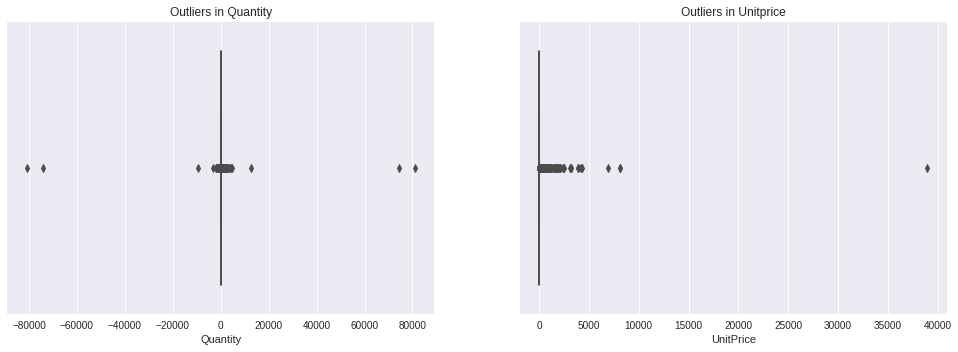

In [151]:
#plot for outliers
plt.style.use('seaborn')

plt.figure(figsize=(15,5))
plt.subplot(121)
sns.boxplot(df['Quantity'])
plt.title('Outliers in Quantity')

plt.subplot(122)
sns.boxplot(df['UnitPrice'])
plt.title('Outliers in Unitprice')


Proceeding without cliping the outliers because there are many outliers in data. Cliping them may lose key informations

**3.4 Exploratory Data Analysis**

In [152]:
# Creating new column 'Sales' 
df['Sales'] = df['Quantity'] * df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34


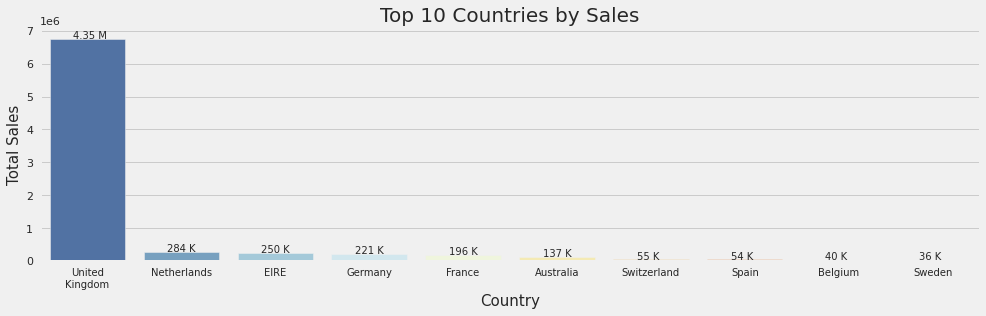

In [238]:
# Visualising Top 10 Countries by Sales
country_grouped_Sales = df.groupby('Country')['Sales'].sum().nlargest(10)
plt.figure(figsize = (15,4))
ax = sns.barplot(x = country_grouped_Sales.index, y = country_grouped_Sales.values, palette = 'RdYlBu_r')
ax.set_xlabel('Country', fontsize = 15)
ax.set_ylabel('Total Sales', fontsize = 15)
ax.set_title('Top 10 Countries by Sales', fontsize = 20)

labels = [ '\n'.join(wrap(l, 12)) for l in country_grouped_Sales.index ]
ax.set_xticklabels(labels, fontsize = 10)

value_labels = []
for x in country_grouped_Sales.values:
    value_labels.append(str(int(x/1000))+' K')
value_labels[0] = '4.35 M'

for p, label in zip(ax.patches, value_labels):
    ax.annotate(label, (p.get_x() + 0.25, p.get_height()), fontsize = 10)


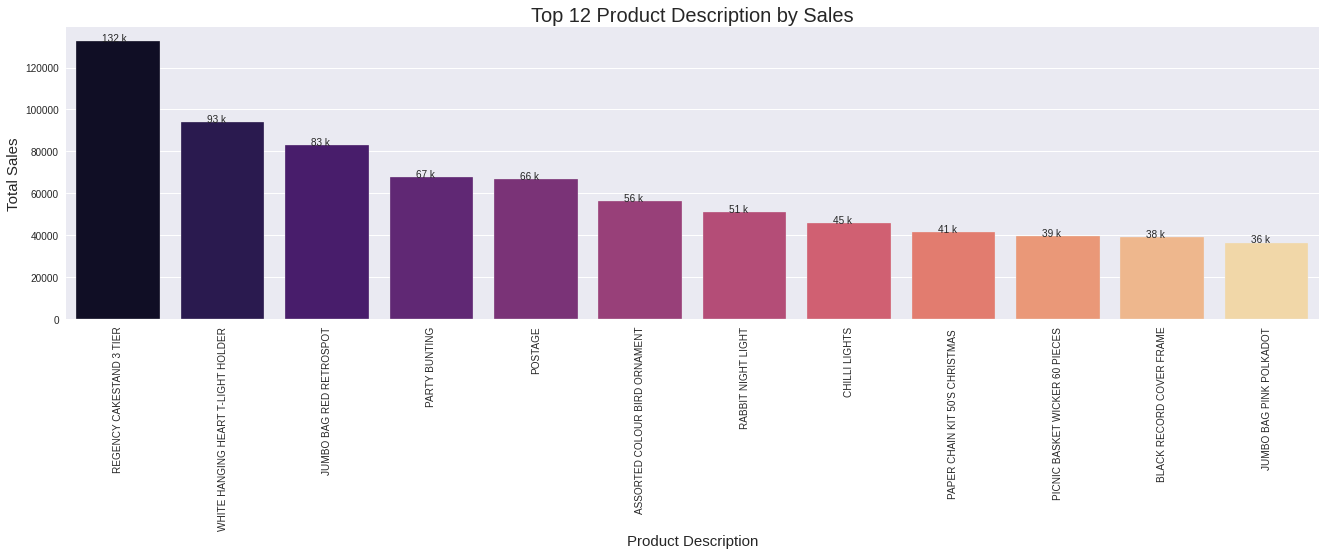

In [154]:
# Visulaising top 15 product Description by Sales
product_order = df.groupby('Description')['Sales'].sum().nlargest(12)

plt.figure(figsize = (20,5))
ax = sns.barplot(x = product_order.index, y = product_order.values, palette = 'magma')
ax.set_xlabel('Product Description', fontsize = 15)
ax.set_ylabel('Total Sales', fontsize = 15)
ax.set_title('Top 12 Product Description by Sales', fontsize = 20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
value_labels = []
for x in product_order.values:
    value_labels.append(str(int(x/1000))+' k')

for p, label in zip(ax.patches, value_labels):
    ax.annotate(label, (p.get_x() + 0.25, p.get_height()), fontsize = 10)
     

## ***Text Pre-processing***

**Removing punctuation**

In [155]:
df['Description_processed'] = df['Description'].str.replace("[^a-zA-Z0-9]", " ")

**Removing Short words**

In [156]:
df['Description_processed'] = df['Description_processed'].apply(lambda row: ' '.join([word for word in row.split() if len(word)>2]))

**Converting the document into lower case**

In [157]:
df['Description_processed'] = [row.lower() for row in df['Description_processed']]

**Stop words removal**

In [159]:
stop_words = stopwords.words('english')
add_words = ['felt','spot','colour']
stop_words.extend(add_words)

def remove_stopwords(des):
    description_tokenized = word_tokenize(des)
    des_new = " ".join([i for i in description_tokenized if i not in stop_words])
    return des_new

df['Description_processed'] = [remove_stopwords(r) for r in df['Description_processed']]
     

**Lemmatization**

In [160]:
lemmatizer = WordNetLemmatizer()
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatize_sentence(sentence):
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:        
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

df['Description_processed'] = df['Description_processed'].apply(lambda x: lemmatize_sentence(x))

In [191]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales,Description_processed
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30,hang heart light holder
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34,metal lantern
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00,cream cupid heart coat hanger
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34,knit union flag hot water bottle
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34,woolly hottie heart


In [161]:
df1 = df['Description_processed'].drop_duplicates()

In [162]:
df_desc = pd.DataFrame(df1)
df_desc

,Description_processed
0,hang heart light holder
1,metal lantern
2,cream cupid heart coat hanger
3,knit union flag hot water bottle
4,woolly hottie heart
...,...
503602,ribbon perfectly pretty
504104,ribbon party
530382,crystal skull phone charm
537621,cream hang heart light holder


**Plotting Most frequent words**

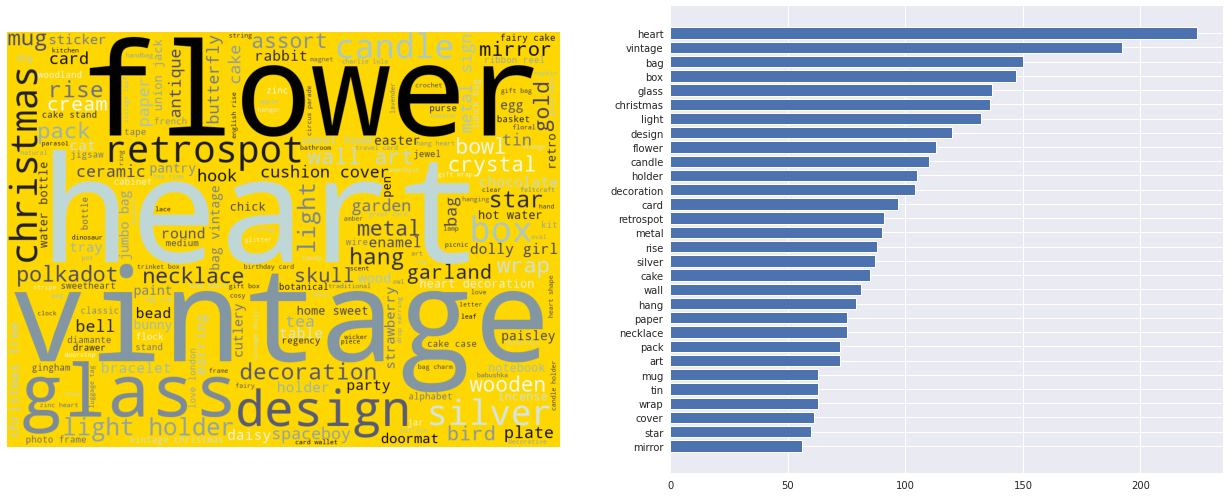

In [163]:
# Visualizing most frequent words in 'Description' 

plt.figure(1,figsize=(30,8))
plt.subplot(131)    
# Plotting Frequent word using wordcloud

all_words = ' '.join([text for text in df_desc['Description_processed']])
wordcloud = WordCloud(width = 1000, height = 750, background_color ='gold', min_font_size = 10,colormap = 'bone').generate(all_words)
plt.imshow(wordcloud) 
plt.axis("off") 

plt.subplot(132)
# Plotting most frequent words using bar chart
sns.set(style = 'dark')
#Extracts words into list and count frequency
all_words = all_words.split()
words_df = FreqDist(all_words)
# Extracting words and frequency from words_df object
words_df = pd.DataFrame({'word':list(words_df.keys()), 'count':list(words_df.values())})
# Subsets top 30 words by frequency
words_df = words_df.nlargest(columns="count", n = 30) 
words_df.sort_values('count', inplace = True)
# Plotting 30 frequent words
# plt.figure(figsize=(20,5))
ax = plt.barh(words_df['word'], width = words_df['count'])
plt.show()



**Bag of Words Model - Using Tf–idf term weighting**

In [165]:
tfidf = TfidfVectorizer(max_features=2500)
vectors = tfidf.fit_transform(df_desc['Description_processed']).toarray()
featureNames = tfidf.get_feature_names()
X_tfidf = pd.DataFrame(vectors,columns=featureNames)
print("n_samples: %d, n_features: %d" % X_tfidf.shape)
print(X_tfidf.shape)
X_tfidf.head()

n_samples: 3363, n_features: 1736
(3363, 1736)


,120cm,125g,15c,15cm,16x16cm,17080,18pc,200,20light,250g,...,work,world,woven,wrap,wreath,wreck,write,xmas,yuletide,zinc
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# **Clustering Products**

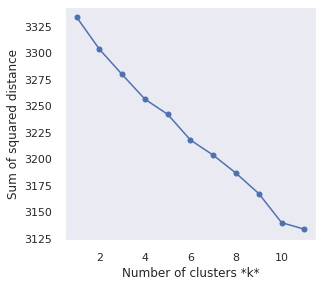

In [166]:
from sklearn.cluster import KMeans

list_k = list(range(1, 12))
inertias = []
for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X_tfidf)
    inertias.append(km.inertia_)

# Plotting
plt.figure(figsize=(4, 4))
plt.plot(list_k, inertias, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance'); 

*INTERPRETATION* of the above Elbow plot:

Since, we didn't get the optimum k-value, we need to reduce the number of feature using Dimensionality Reduction.

**4.7 Principal component analysis (PCA)** --> for Dimensionality Reduction

In [240]:
components = None
pca = PCA(n_components = components)
pca.fit(X_tfidf)
     

PCA()

Number of components: 624


Text(0, 0.5, 'Explained variance (%)')

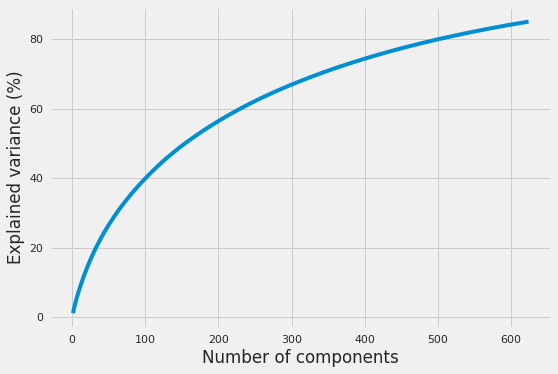

In [241]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 0.85)
pca.fit(X_tfidf)

# optimum no:of components
components = len(pca.explained_variance_ratio_)
print(f'Number of components: {components}')

# Make the scree plot
plt.plot(range(1, components + 1), np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Number of components")
plt.ylabel("Explained variance (%)")

*INTERPRETATION* of the plot:
By choosing the 85% of Variance we can reduce the dimension upto 600

In [173]:
from sklearn.decomposition import PCA

pca = PCA(625)
PCA_data = pca.fit_transform(X_tfidf)
PCA_data.shape 

(3363, 625)

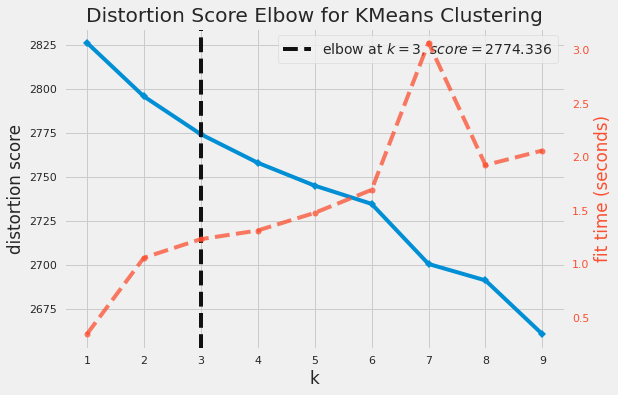

In [177]:
#finding the optimum value for K for clustering products
from yellowbrick.cluster import KElbowVisualizer
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(1,10)).fit(PCA_data)
visualizer.show()

*INTERPRETATION* of the above Elbow plot:

The optimum k-value occurs at 3 (k = 3) ie. 3 clusters for products

In [271]:
km = KMeans(n_clusters=3,init="k-means++",random_state=42)  
km.fit(PCA_data) 
centroids = km.cluster_centers_  
print("centroids: \n",centroids)
print("\ninertia: ",km.inertia_)  # measures how tight my groups are. Lower the better

centroids: 
 [[ 4.60030964e-02  3.01475650e-01 -2.26358113e-02 ... -1.13204588e-05
  -2.73912584e-06 -1.97251830e-04]
 [ 1.66878279e-01 -3.55992632e-02  2.03415359e-01 ...  1.04163217e-05
  -4.48301247e-04 -3.03269024e-04]
 [-1.79156923e-02 -1.05388379e-02 -1.82070607e-02 ... -4.63558806e-07
   4.25537887e-05  3.78013251e-05]]

inertia:  2774.336357407142


In [272]:
#predict the labels of clusters
label = km.fit_predict(PCA_data)  
print(label)

[1 2 2 ... 2 1 2]


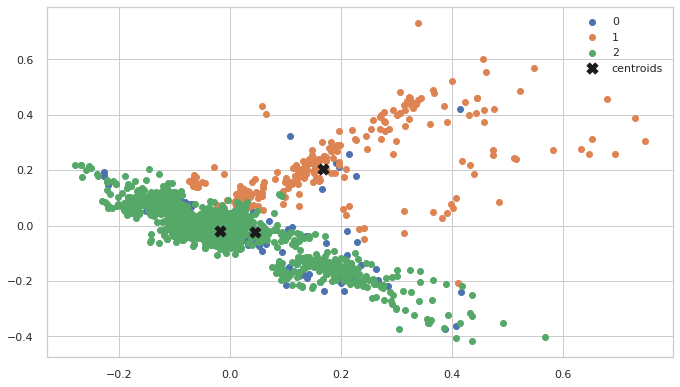

In [273]:
centroids = km.cluster_centers_   
u_labels = np.unique(label)      
 
# plotting the results:
plt.figure(figsize=(10, 6)) 
for i in u_labels:
    plt.scatter(PCA_data[label == i , 0] , PCA_data[label == i , 2] , label = i)
plt.scatter(centroids[:,0] , centroids[:,2] , marker="X", c="k", s=120, label="centroids")
plt.legend()
plt.show()
     

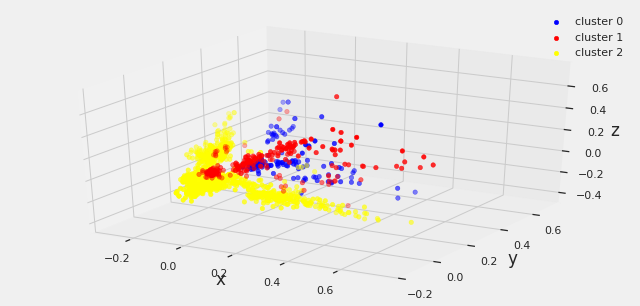

In [182]:
#ploting in 2d projection
labels = np.unique(label)  

fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(PCA_data[label == 0,0],PCA_data[label == 0,1],PCA_data[label == 0,2], s = 20 , color = 'blue', label = "cluster 0")  
ax.scatter(PCA_data[label == 1,0],PCA_data[label == 1,1],PCA_data[label == 1,2], s = 20 , color = 'red', label = "cluster 1")  
ax.scatter(PCA_data[label == 2,0],PCA_data[label == 2,1],PCA_data[label == 2,2], s = 20 , color = 'yellow', label = "cluster 2")  
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend()
plt.show()

Creating a dataframe cluster labels and merge into original dataframe

In [184]:
# creating a dataframe for the cluster labels:
df3 = pd.DataFrame(km.labels_)
print(df3.shape)
df3

(3363, 1)


,0
0,1
1,2
2,2
3,2
4,2
...,...
3358,2
3359,2
3360,2
3361,1


In [185]:
print(df_desc.shape)
df_desc     

(3363, 1)


,Description_processed
0,hang heart light holder
1,metal lantern
2,cream cupid heart coat hanger
3,knit union flag hot water bottle
4,woolly hottie heart
...,...
503602,ribbon perfectly pretty
504104,ribbon party
530382,crystal skull phone charm
537621,cream hang heart light holder


In [186]:
df_desc = df_desc.reset_index(drop=True) 

In [188]:
df_prod = df_desc.join(df3)
df_prod.head()

,Description_processed,0
0,hang heart light holder,1
1,metal lantern,2
2,cream cupid heart coat hanger,2
3,knit union flag hot water bottle,2
4,woolly hottie heart,2


In [189]:
df_prod.rename(columns={0:'Product Cluster'},inplace=True) 

In [192]:
df_new = pd.merge(df, df_prod, how='left', on='Description_processed')

In [193]:
df_new

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales,Description_processed,Product Cluster
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30,hang heart light holder,1
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34,metal lantern,2
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00,cream cupid heart coat hanger,2
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34,knit union flag hot water bottle,2
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34,woolly hottie heart,2
...,...,...,...,...,...,...,...,...,...,...,...
401599,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France,10.20,pack spaceboy napkin,2
401600,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France,12.60,child apron dolly girl,2
401601,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France,16.60,childrens cutlery dolly girl,2
401602,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France,16.60,childrens cutlery circus parade,2


Encoding the Country, Product clusters columns

In [194]:
df_new_1 = pd.get_dummies(df_new,columns=["Product Cluster"])
df_new_1.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales,Description_processed,Product Cluster_0,Product Cluster_1,Product Cluster_2
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30,hang heart light holder,0,1,0
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34,metal lantern,0,0,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00,cream cupid heart coat hanger,0,0,1


# **Clustering Customers**

In [195]:
df_new_2 = df_new_1.copy()

In [198]:
# Dropping unnecessary features:
df_new_2= df_new_2.drop(["InvoiceNo","StockCode","Description","InvoiceDate","Description_processed"],axis=1)
df_new_2.head()

,Quantity,UnitPrice,CustomerID,Country,Sales,Product Cluster_0,Product Cluster_1,Product Cluster_2
0,6,2.55,17850.0,United Kingdom,15.30,0,1,0
1,6,3.39,17850.0,United Kingdom,20.34,0,0,1
2,8,2.75,17850.0,United Kingdom,22.00,0,0,1
3,6,3.39,17850.0,United Kingdom,20.34,0,0,1
4,6,3.39,17850.0,United Kingdom,20.34,0,0,1


In [200]:
df_new_encode = pd.get_dummies(df_new_2,columns=["Country"])


In [201]:
df_new_encode.head()

,Quantity,UnitPrice,CustomerID,Sales,Product Cluster_0,Product Cluster_1,Product Cluster_2,Country_Australia,Country_Austria,Country_Bahrain,...,Country_RSA,Country_Saudi Arabia,Country_Singapore,Country_Spain,Country_Sweden,Country_Switzerland,Country_USA,Country_United Arab Emirates,Country_United Kingdom,Country_Unspecified
0,6,2.55,17850.0,15.30,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,6,3.39,17850.0,20.34,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,8,2.75,17850.0,22.00,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,6,3.39,17850.0,20.34,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,6,3.39,17850.0,20.34,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [274]:
from sklearn.preprocessing import LabelEncoder 
label_encoder = LabelEncoder() 
#encoding the customer
df_new_encode['CustomerID']= label_encoder.fit_transform(df_new_encode['CustomerID'])

In [275]:
print(df_new_encode.shape)
df_new_encode.head()

(401604, 44)


,Quantity,UnitPrice,CustomerID,Sales,Product Cluster_0,Product Cluster_1,Product Cluster_2,Country_Australia,Country_Austria,Country_Bahrain,...,Country_RSA,Country_Saudi Arabia,Country_Singapore,Country_Spain,Country_Sweden,Country_Switzerland,Country_USA,Country_United Arab Emirates,Country_United Kingdom,Country_Unspecified
0,6,2.55,4048,15.30,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,6,3.39,4048,20.34,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,8,2.75,4048,22.00,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,6,3.39,4048,20.34,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,6,3.39,4048,20.34,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [258]:
print("No.of unique Customers: ",df_new_encode['CustomerID'].nunique())

No.of unique Customers:  4372


In [205]:
df_grp_encode = df_new_encode.groupby(['CustomerID']).mean()


In [213]:
df_grp_encode1 = df_new_encode.groupby(['CustomerID'])

In [214]:
df_grp_encode1

In [207]:
df_grp_encode.tail()

,Quantity,UnitPrice,Sales,Product Cluster_0,Product Cluster_1,Product Cluster_2,Country_Australia,Country_Austria,Country_Bahrain,Country_Belgium,...,Country_RSA,Country_Saudi Arabia,Country_Singapore,Country_Spain,Country_Sweden,Country_Switzerland,Country_USA,Country_United Arab Emirates,Country_United Kingdom,Country_Unspecified
CustomerID,,,,,,,,,,,,,,,,,,,,,
4367,4.500000,4.765000,18.060000,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4368,7.714286,5.622857,11.545714,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4369,7.538462,4.821538,13.584615,0.076923,0.000000,0.923077,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4370,1.882108,1.628752,2.837074,0.081831,0.018031,0.900139,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4371,22.657143,1.493571,26.246857,0.142857,0.128571,0.728571,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [248]:
y = df_grp_encode.to_numpy()

In [249]:
y.shape

(4372, 43)

Scaling

In [250]:
sc = MinMaxScaler()
y_scaled = sc.fit_transform(y)

**Visualizing Elbow plot**

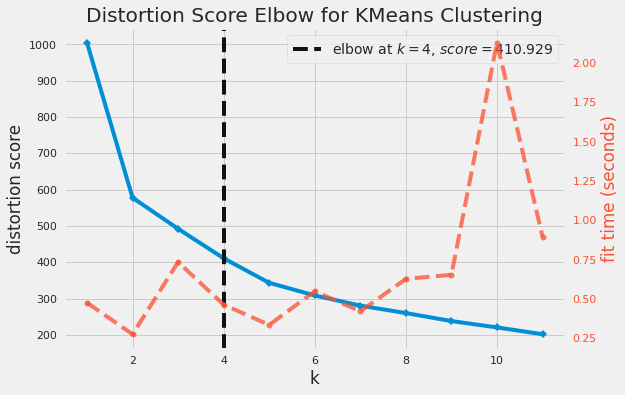

In [244]:
model = KMeans(random_state=9)
visualizer = KElbowVisualizer(model, k=(1,12)).fit(y_scaled)
visualizer.show()
     

INTERPRETATION of the above Elbow plot:

The optimum k-value occurs at 4 (k = 4) ie. 4 clusters 

**Modelling**

In [245]:
km = KMeans(n_clusters=4, init= "k-means++", random_state=9)     # applying k = 4
km.fit(y_scaled) # fit the data - identify pattern, does everything

centroids = km.cluster_centers_   # final centroid points


print("inertia: ",km.inertia_)    # measures how tight my groups are. Lower the better

inertia:  410.92903153592005


In [218]:
km.labels_ 

array([0, 3, 3, ..., 0, 0, 0], dtype=int32)

In [263]:
# predict the labels of clusters
label = km.fit_predict(y_scaled)  
print(label)

[0 3 3 ... 0 0 0]


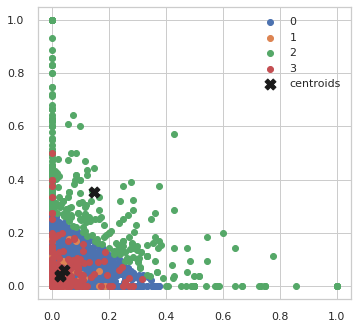

In [265]:
# Getting the Centroids and Cluster labels
centroids = km.cluster_centers_
labels = np.unique(label)

# 2D plotting
plt.figure(figsize=(5, 5)) 
for i in labels:
    plt.scatter(y_scaled[label == i , 3] , y_scaled[label == i , 4] , label = i)
plt.scatter(centroids[:,3] , centroids[:,4] , marker="X", c="k", s=120, label="centroids")
plt.legend()
plt.show()

In [264]:
np.unique(label)

array([0, 1, 2, 3], dtype=int32)

*INTERPRETATION* of the above plot:

since the datapoints are closer to each other, there is no clear cluster formed.

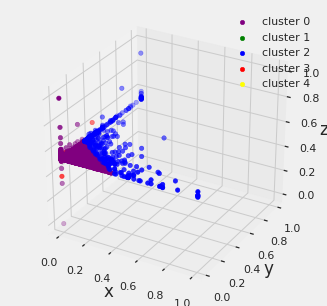

In [221]:
# 3D plotting
labels = np.unique(label)

fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(y_scaled[label == 0,3],y_scaled[label == 0,4],y_scaled[label == 0,2], s = 20 , color = 'purple', label = "cluster 0")  
ax.scatter(y_scaled[label == 1,3],y_scaled[label == 1,4],y_scaled[label == 1,2], s = 20 , color = 'green', label = "cluster 1")  
ax.scatter(y_scaled[label == 2,3],y_scaled[label == 2,4],y_scaled[label == 2,2], s = 20 , color = 'blue', label = "cluster 2")  
ax.scatter(y_scaled[label == 3,3],y_scaled[label == 3,4],y_scaled[label == 3,2], s = 20 , color = 'red', label = "cluster 3")  
ax.scatter(y_scaled[label == 4,3],y_scaled[label == 4,4],y_scaled[label == 4,2], s = 20 , color = 'yellow', label = "cluster 4")  

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend()
plt.show()

**Dataframe for Customer cluster**

In [222]:
df_final = pd.DataFrame(label) # creating a dataframe for the "customer clusters"

In [223]:
df_final.reset_index(level=0, inplace=True) # creating the "customerID" column

In [225]:
df_final.rename(columns={'index':'CustomerID', 0:'Customer cluster'},inplace=True) # renaming the columns

In [227]:
df_final

,CustomerID,Customer cluster
0,0,0
1,1,3
2,2,3
3,3,3
4,4,3
...,...,...
4367,4367,0
4368,4368,0
4369,4369,0
4370,4370,0


In [228]:
# count of each clusters
df_cus_count = df_final.groupby("Customer cluster").count()
df_cus_count
     

,CustomerID
Customer cluster,
0,3583
1,95
2,367
3,327


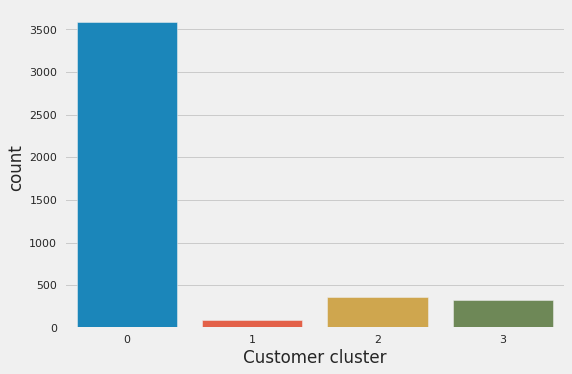

In [235]:
#number of CUSTOMERS in each cluster
sns.countplot(df_final["Customer cluster"])

*Interpretation* of plot:

cluster 0 has more customers followed by cluster 2 

In [242]:
from sklearn import metrics
score = metrics.silhouette_score(y_scaled, km.labels_ )
print("silhouette_score: ",score)

silhouette_score:  0.6408173706212982


*Interpretation* of Silhouette score:

Score of 0.64 shows that the clusters are not well seprated from each other

**Summary:**

We have grouped the customer into 4 clusters based on   
  *   Products they bought
  *   Country they belong
  *   Quantity of products they bought



